In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import time

2024-07-30 18:27:33.547535: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 18:27:33.547646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 18:27:33.705286: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set the base directory for the dataset
base_skin_dir = '../input/skin-cancer-mnist-ham10000'

# Load metadata
metadata_path = os.path.join(base_skin_dir, 'HAM10000_metadata.csv')
metadata_df = pd.read_csv(metadata_path)

In [3]:
# Map image paths
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}
metadata_df['path'] = metadata_df['image_id'].apply(lambda x: imageid_path_dict.get(x))

# Define lesion types
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratosis',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
metadata_df['cell_type'] = metadata_df['dx'].map(lesion_type_dict.get)
metadata_df['cell_type_idx'] = pd.Categorical(metadata_df['cell_type']).codes

# Print initial class distribution
print("Initial class distribution:")
print(metadata_df['cell_type'].value_counts())

# Subsample data: take half of the images from each class
sampled_df = metadata_df.groupby('cell_type').apply(lambda x: x.sample(frac=1.0)).reset_index(drop=True)
print("\nReduced class distribution:")
print(sampled_df['cell_type'].value_counts())

Initial class distribution:
cell_type
Melanocytic nevi                 6705
Melanoma                         1113
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratosis                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: count, dtype: int64

Reduced class distribution:
cell_type
Melanocytic nevi                 6705
Melanoma                         1113
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratosis                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: count, dtype: int64


/tmp/ipykernel_34/4102812478.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = metadata_df.groupby('cell_type').apply(lambda x: x.sample(frac=1.0)).reset_index(drop=True)


In [5]:
# Split data into train and test sets
train_df, test_df = train_test_split(sampled_df, test_size=0.20, random_state=42)

In [6]:
# ImageDataGenerator for data augmentation and loading
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

In [7]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='path',
    y_col='cell_type',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 8012 validated image filenames belonging to 7 classes.


In [8]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='path',
    y_col='cell_type',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 2003 validated image filenames belonging to 7 classes.


In [9]:
# Build the model using EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Add dropout with a 50% rate to reduce overfitting
predictions = Dense(len(lesion_type_dict), activation='softmax', kernel_regularizer=l2(0.01))(x)
model = Model(inputs=base_model.input, outputs=predictions)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Measure start time
start_time = time.time()

# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=20
)

# Measure end time
end_time = time.time()
total_train_time = end_time - start_time

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1722364193.643864      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722364193.746075      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 64/250 ━━━━━━━━━━━━━━━━━━━━ 5:01 2s/step - accuracy: 0.6136 - loss: 1.2690  

W0000 00:00:1722364295.656148      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.6986 - loss: 0.9955

W0000 00:00:1722364439.760783      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


250/250 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.6988 - loss: 0.9949 - val_accuracy: 0.0544 - val_loss: 2.0484
Epoch 2/20
  1/250 ━━━━━━━━━━━━━━━━━━━━ 42s 170ms/step - accuracy: 0.6250 - loss: 1.0929

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.6250 - loss: 1.0929 - val_accuracy: 0.1579 - val_loss: 1.8447
Epoch 3/20


W0000 00:00:1722364475.825080      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


250/250 ━━━━━━━━━━━━━━━━━━━━ 139s 540ms/step - accuracy: 0.7893 - loss: 0.6332 - val_accuracy: 0.3780 - val_loss: 1.8048
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - accuracy: 0.8750 - loss: 0.3415 - val_accuracy: 0.5263 - val_loss: 1.5881
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 138s 538ms/step - accuracy: 0.8225 - loss: 0.5152 - val_accuracy: 0.6613 - val_loss: 1.3979
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step - accuracy: 0.6875 - loss: 0.6864 - val_accuracy: 0.5263 - val_loss: 1.5876
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 139s 541ms/step - accuracy: 0.8438 - loss: 0.4673 - val_accuracy: 0.7656 - val_loss: 0.7816
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step - accuracy: 0.7812 - loss: 0.4422 - val_accuracy: 0.8421 - val_loss: 0.6971
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 139s 540ms/step - accuracy: 0.8664 - loss: 0.4112 - val_accuracy: 0.7560 - val_loss: 0.7184
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step - accuracy: 0.8750 - loss: 0.3304 - va

In [12]:
# Evaluate the model
_, accuracy = model.evaluate(test_generator)
print('Test accuracy:', accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - accuracy: 0.7728 - loss: 0.7862
Test accuracy: 0.7773339748382568


In [13]:
# Model parameters
total_params = model.count_params()
trainable_params = np.sum([np.prod(layer.get_weights()[0].shape) for layer in model.layers if len(layer.get_weights()) > 0])
non_trainable_params = total_params - trainable_params

print('Total number of parameters:', total_params)
print('Number of trainable parameters:', trainable_params)
print('Number of non-trainable parameters:', non_trainable_params)

# Total train time
print('Total train time: {:.2f} seconds'.format(total_train_time))

Total number of parameters: 4058538
Number of trainable parameters: 3986163
Number of non-trainable parameters: 72375
Total train time: 1644.22 seconds


In [14]:
# Confusion matrix
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred)

 1/63 ━━━━━━━━━━━━━━━━━━━━ 5:57 6s/step

W0000 00:00:1722365752.701697      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 283ms/step


W0000 00:00:1722365770.235152      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [15]:
# Precision, Recall, and F1-score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 Score: {:.2f}'.format(f1))

Precision: 0.48
Recall: 0.53
F1 Score: 0.51


In [24]:
def plot_confusion_matrix(cm, classes, figsize=(10, 8)):
    """
    Plot the confusion matrix with numbers and percentages inside each cell.
    
    Parameters:
    cm (np.array): Confusion matrix
    classes (list): List of class names
    figsize (tuple): Size of the plot
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Calculate percentages row-wise
    for i in range(cm.shape[0]):
        row_sum = np.sum(cm[i, :])
        for j in range(cm.shape[1]):
            percentage = cm[i, j] / row_sum if row_sum > 0 else 0
            text = f'{cm[i, j]}\n({percentage:.2f})'
            plt.text(j, i, text,
                     ha='center', va='center',
                     color='white' if cm[i, j] > cm.max() / 2. else 'black')
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

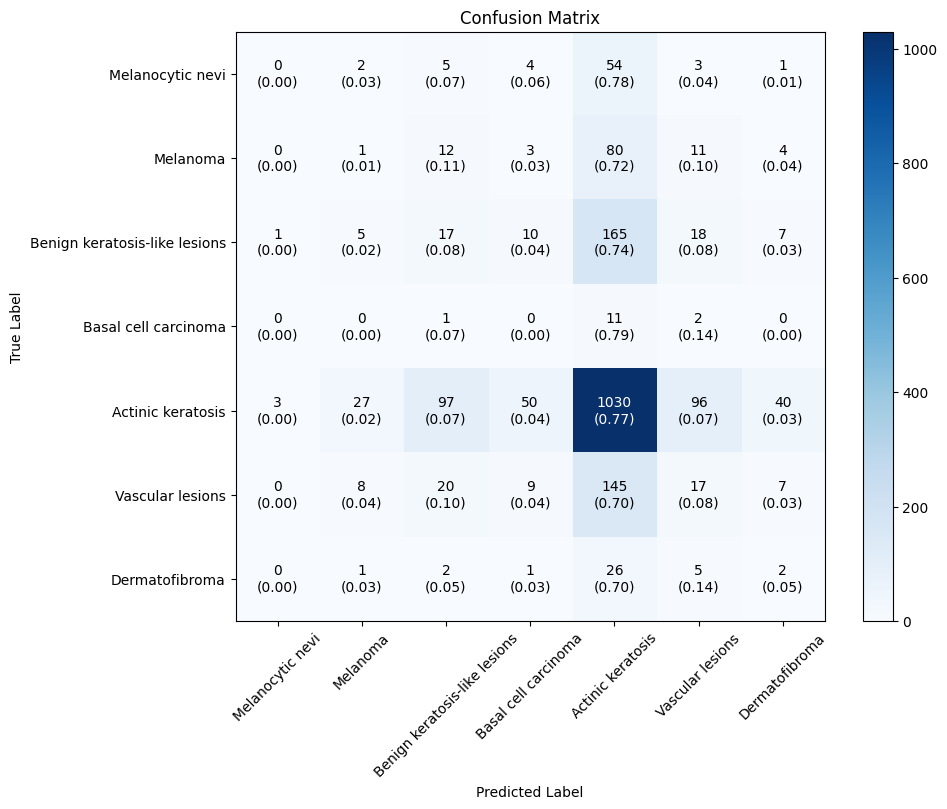

In [25]:
class_names = list(lesion_type_dict.values())
plot_confusion_matrix(cm, class_names)